# Final Report Experiments

This notebook contains the required modules for running experiments for the final report in Introduction to Deep Learning (11-785) course. The notebook is organized into the following sections:

1.
2.


In [ ]:
!nvidia-smi

Wed Nov 26 04:24:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:16:00.0 Off |                    0 |
| N/A   35C    P0             63W /  300W |       1MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Imports

In [5]:
!pip install wandb --quiet # Install WandB
!pip install pytorch_metric_learning --quiet # Install the Pytorch Metric Library
!pip install torchinfo --quiet # Install torchinfo
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 15.1 MB/s eta 0:00:00


In [20]:
!pip install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.5 MB/s eta 0:00:00


In [6]:
import os
import gc
import csv
import glob
import random
import warnings

import numpy as np
import pandas as pd
import wandb
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from scipy.optimize import brentq
from scipy.interpolate import interp1d


from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from PIL import Image

# PyTorch
import torch
from torchsummary import summary
import torchvision
import torchaudio
from torchvision.utils import make_grid
from torchvision import transforms
import torchvision.transforms.v2 as T
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from pytorch_metric_learning import samplers
from torchmetrics import F1Score

#
from transformers import Wav2Vec2Model
from peft import LoraConfig, get_peft_model

In [7]:
warnings.filterwarnings("ignore")

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cpu


In [8]:
!mkdir -p /content/data
!gdown https://drive.google.com/uc?id=1EZs76l2FYUJqEyCPqrKvTopee3TXnHxn
!unzip -q task1_split.zip -d /content/data/

Downloading...
From (original): https://drive.google.com/uc?id=1EZs76l2FYUJqEyCPqrKvTopee3TXnHxn
From (redirected): https://drive.google.com/uc?id=1EZs76l2FYUJqEyCPqrKvTopee3TXnHxn&confirm=t&uuid=44d4f323-a81d-496b-b1c8-4f6718e764ae
To: /content/task1_split.zip
100% 414M/414M [00:07<00:00, 54.1MB/s]


## Configs

In [9]:
WAV2VEC_MODEL = "facebook/wav2vec2-base-960h"
CACHE_DIR = "" # ADD CACHE DIR

In [40]:
config = {
    # ----- Problem Configs -----
    "subset" : 1,
    "task_num" : 1,
    "fs" : 8000, # in Hz
    "max_len" : 5, # in seconds

    # ----- Data Configs -----
    "train_dir" : "/content/data/task1_split/train", # ADD DIR
    "val_dir" :  "/content/data/task1_split/val", # ADD DIR
    "test_dir" :  "/content/data/task1_split/test", # ADD DIR
    "metadata_path": "/content/data/task1_split/sand_task_1.xlsx",

    ## ----- Model Configs -----
    "feature_extractor": "wav2vec_lora",   # wav2vec_lora or wav2vec_vanilla
    "post_processor": "none",              # lstm or none
    # shared dim for all modes
    "feature_dim": 768,

    # ---- attention pooling ----
    # used only when mode == "attention"
    "attention_dim": 768,

    # ---- conv pooling ----
    # used only when mode == "conv"
    "conv_kernel_size": 5,
    "conv_padding": 2,

    # ---- multihead pooling ----
    # used only when mode == "multihead"
    "multihead_num_heads": 4,
    "classifier": "mlp",                   # or linear

    "hidden_dim": 768,
    "num_layers": 2,
    "num_classes": 6,
    "lora_r": 8,
    "lora_alpha": 16,

    # ----- Training Configs -----
    'batch_size': 3, # Increase this if your GPU can handle it
    'lr': 1e-6,
    "weight_decay" : 1e-4,
    'epochs': 50,
    'num_classes': 5,
    'checkpoint_dir': "./checkpoints",
    'augument': True,
    'ablation_ID': 22
}

random.seed(42)

In [11]:
phonation_list = ["phonationA",
                  "phonationE",
                  "phonationI",
                  "phonationO",
                  "phonationU",
                  "rhythmKA",
                  "rhythmPA",
                  "rhythmTA"]

## Data Augmentation

In [21]:
class Wav2VecAugment:
    def __init__(self,
                p_noise=0.3,
                p_gain=0.3,
                p_flip=0.1,
                p_shift=0.3,
                p_filter=0.3,
                p_speed=0.2,
                sample_rate=config["fs"]):
        self.p_noise = p_noise
        self.p_gain = p_gain
        self.p_flip = p_flip # Flip polarity (not implemented)
        self.p_shift = p_shift # Time shift (not implemented)
        self.p_filter = p_filter # Simple HPF (not implemented)
        self.p_speed = p_speed
        self.sample_rate = sample_rate


    def __call__(self, waveform):
        """
        Input:
            waveform :
                - Input wavefrom
                - Type: tesnsor
                - Shape : [T]
        """
        # ----- Gaussian Noise -----
        if random.random() < self.p_noise:
            noise_amp = (0.01 * random.random()) * torch.rand_like(waveform)
            waveform = waveform + noise_amp

        # ----- Volume Augmentation -----
        if random.random() < self.p_gain:
            gain_db = random.uniform(-6, 6)
            gain = 10**(gain_db/20)
            waveform = waveform*gain

        # ----- Speed Change -----
        if random.random() < self.p_speed:
            speed_factor = random.uniform(0.8, 1.2)
            waveform = self.time_stretch(waveform, speed_factor)

        return waveform

    def time_stretch(self, waveform, speed_factor):
        new_sample_rate = int(self.sample_rate * speed_factor)
        resampler = torchaudio.transforms.Resample(orig_freq=self.sample_rate, new_freq=new_sample_rate)
        return resampler(waveform)

## Data Loaders

In [22]:
class Wav2VecAudioMultiPhonationDataset(Dataset):
    def __init__(self,
                 root_dir,
                 phonation_types,
                 set_type,
                 original_fs=config["fs"],
                 new_fs=16_000,
                 metadata_file="sand_task_1.xlsx",
                 metadata_path=None,
                 augment=False):
        self.root_dir = root_dir
        self.phonation_types = phonation_types
        self.set_type = set_type
        self.augment = augment
        self.original_fs = original_fs
        self.new_fs = new_fs

        # ----- Data Augmentaion -----
        self.transform = Wav2VecAugment() if augment else None

        # ----- Load Meta Data -----
        if metadata_path is None:
          metadata_path = os.path.join(root_dir, metadata_file)
          self.metadata_df = pd.read_excel(metadata_path)
        else:
          self.metadata_df = pd.read_excel(metadata_path)

        if (self.set_type != "test"):
            self.id_to_label = dict(zip( self.metadata_df["ID"], self.metadata_df["Class"] ))
        else:
            self.id_to_label = None

        # ----- Identify Subjects -----
        self.subject_ids = self._collect_valid_subject_ids()

        # ----- Resampling ----- (not needed, functional is used, robust to multi-freq recordings)
        # self.resampler = torchaudio.transforms.Resample(orig_freq=original_fs,
                                                       # new_freq=new_fs)

    def _collect_valid_subject_ids(self):
        phonation_files = {}
        for phonation in self.phonation_types:
            phonation_path = os.path.join(self.root_dir, phonation)
            files = os.listdir(phonation_path)
            files = os.listdir(phonation_path)
            ids = set(f.split('_')[0] for f in files if f.endswith('.wav'))
            phonation_files[phonation] = ids

        valid_ids = set.intersection(*phonation_files.values())
        valid_ids = valid_ids.intersection(
            set(str(id_) for id_ in self.metadata_df['ID'])
        )

        return sorted(valid_ids)

    def __len__(self):
        return len(self.subject_ids)

    def __getitem__(self, idx):
        """
        Input(s):
            idx:
                - sample index (0-based)
                - type: int
                - shape: (1,)

        Output(s):
            recordings:
                - Recordings of different phonations from the same person.
                - type: list
                - shape: (num_phonations, ?). The second dimension is "?" because each recording has a different number of samples.
            label:
                - sample class label (0-based). There are 5 classes in total, so label in [0, 4].
                - type: int
                - shape: (1,)
        """
        subject_id = self.subject_ids[idx]
        recordings = []

        for phonation in self.phonation_types:
            # ----- Read audio file -----
            filename = f"{subject_id}_{phonation}.wav"
            filepath = os.path.join(self.root_dir, phonation, filename)
            waveform, sample_rate = torchaudio.load(filepath) # [num_mics, T]
            waveform = waveform.mean(dim=0) # [T]

            # ----- Resample to 16kHz -----
            if sample_rate != 16_000:
                waveform = torchaudio.functional.resample(waveform,
                                                         sample_rate,
                                                         self.new_fs)

            # ----- Apply augmentations -----
            if self.transform:
                waveform = self.transform(waveform)

            recordings.append(waveform)

        if (self.set_type == "test"):
            return recordings
        else:
            label = int(self.id_to_label[subject_id] - 1) # 0-based classes
            return recordings, label

In [23]:
from torch.utils.data import Subset
import random

# subset function
def subset_function(dataset, subset_selection):

    # only use subset if its less than 1
    if subset_selection < 1.0:

        subset_size = int(len(dataset) * subset_selection)
        indices = random.sample(range(len(dataset)), subset_size)
        print(f"Using subset of {subset_size}/{len(dataset)} samples ({subset_selection*100:.0f}%)")
        return Subset(dataset, indices)

    else:

        print(f"Using full dataset ({len(dataset)} samples)")
        return dataset

In [24]:
train_dataset = Wav2VecAudioMultiPhonationDataset(root_dir=config["train_dir"],
                                                  phonation_types=phonation_list,
                                                  set_type="train",
                                                  original_fs=config["fs"],
                                                  new_fs=16_000,
                                                  metadata_file="sand_task_1.xlsx",
                                                  metadata_path=config["metadata_path"],
                                                  augment=True)
train_dataset = subset_function(train_dataset,
                                config['subset'])

val_dataset = Wav2VecAudioMultiPhonationDataset(root_dir=config["val_dir"],
                                                phonation_types=phonation_list,
                                                set_type="val",
                                                original_fs=config["fs"],
                                                new_fs=16_000,
                                                metadata_file="sand_task_1.xlsx",
                                                metadata_path=config["metadata_path"],
                                                augment=False)
val_dataset = subset_function(val_dataset,
                              config['subset'])

test_dataset = Wav2VecAudioMultiPhonationDataset(root_dir=config["val_dir"],
                                          phonation_types=phonation_list,
                                          set_type="test",
                                          original_fs=config["fs"],
                                          new_fs=16_000,
                                          metadata_file="sand_task_1.xlsx",
                                          metadata_path=config["metadata_path"],
                                          augment=False)

test_dataset = subset_function(test_dataset,
                               config['subset'])

Using full dataset (190 samples)
Using full dataset (40 samples)
Using full dataset (40 samples)


## DataLoaders

In [25]:
def collate_fn(batch):
    """
    Input(s):
        batch: list of tuples (audio_tensors, label)
            - audio_tensors: [num_recordings, T], where T is not fixed for r in R.
    """
    audios_list, labels_list = zip(*batch)
    B = len(audios_list)
    R = len(audios_list[0])

    # ----- max len per batch -----
    max_len = max(aud.shape[-1] for subject in audios_list for aud in subject)

    padded_audios = []
    attention_masks = []

    for subject in audios_list: # subject : [R, T]
        subject_padded = []
        subject_mask = []

        for aud in subject: # aud [T] or [1, T]
            if aud.ndim == 2:
                aud = aud.squeeze(0) # remove channel_dim if [1, T]
            L = aud.shape[0]
            pad_amount = max_len - L
            if pad_amount > 0:
                aud = torch.nn.functional.pad(aud, (0, pad_amount))
                mask = torch.cat([torch.ones(L), torch.zeros(pad_amount)])
            else:
                mask = torch.ones(L)

            subject_padded.append(aud) # [T_max]
            subject_mask.append(mask) # [T_max]

        padded_audios.append(torch.stack(subject_padded)) # [R, T_max]
        attention_masks.append(torch.stack(subject_mask)) # [R, T_max]

    # [B, R, T]
    padded_audios = torch.stack(padded_audios)
    attention_masks = torch.stack(attention_masks)
    labels = torch.tensor(labels_list)

    return padded_audios, attention_masks, labels

In [26]:
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=4, pin_memory=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False,  num_workers=4, pin_memory=True, collate_fn=collate_fn)
test_loader  = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False,  num_workers=4, pin_memory=True, collate_fn=collate_fn)

## Data Visualization

wavs shape: torch.Size([3, 8, 350720])
attn_mask shape: torch.Size([3, 8, 350720])
labels shape: torch.Size([3])
labels: tensor([4, 3, 2])


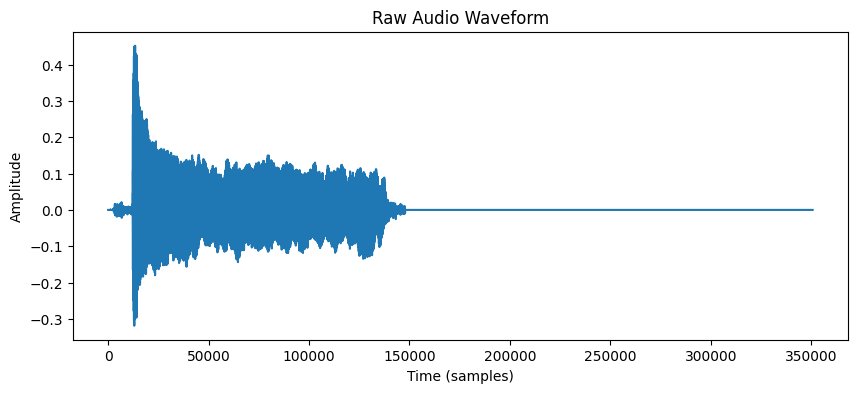

In [27]:
import matplotlib.pyplot as plt

for i, data in enumerate(val_loader):
    wavs, attn_mask, labels = data

    print("wavs shape:", wavs.shape)          # [B, R, T]
    print("attn_mask shape:", attn_mask.shape)
    print("labels shape:", labels.shape)
    print("labels:", labels)

    # Visualize the first audio example
    plt.figure(figsize=(10, 4))
    plt.plot(wavs[0][0].numpy())
    plt.title("Raw Audio Waveform")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()

    break


## Model Architecture

### Wav2Vec

In [28]:
class Wav2VecVanilla(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.wav2vec = Wav2Vec2Model.from_pretrained(WAV2VEC_MODEL,
                                                   output_hidden_states=False,
                                                   cache_dir=CACHE_DIR)
        self.output_dim = self.wav2vec.config.hidden_size

    def _compute_feat_mask(self, attention_mask):
        """
        Convert input attention mask [B, T_samples] into
        downsampled feature mask [B, T_feat].
        """
        device = attention_mask.device
        B, T = attention_mask.shape

        input_lengths = attention_mask.sum(dim=1)  # [B]

        feat_lengths = self.wav2vec._get_feat_extract_output_lengths(input_lengths)

        max_feat_len = self.wav2vec._get_feat_extract_output_lengths(
            torch.tensor([T], device=device)
        )[0]

        feat_mask = torch.arange(max_feat_len, device=device)[None, :] < feat_lengths[:, None]
        return feat_mask  # bool or uint8, shape [B, T_feat]

    def forward(self, wavs, attention_mask):
        out = self.wav2vec(wavs, attention_mask=attention_mask)
        hidden = out.last_hidden_state # [B, T_feat, 768]
        feat_mask = self._compute_feat_mask(attention_mask)
        return hidden, feat_mask

In [29]:
class Wav2VecLoRA(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.base = Wav2Vec2Model.from_pretrained(WAV2VEC_MODEL,
                                           output_hidden_states=False,
                                           cache_dir=CACHE_DIR)
        self.output_dim = self.base.config.hidden_size

        # ----- LoRA -----
        lora_cfg = LoraConfig(
            r=config.get("lora_r", 1),
            lora_alpha=config.get("lora_alpha", 16),
            target_modules=config.get("target_modules", ["q_proj", "k_proj", "v_proj"]), # can also do just ["q_proj"]
            lora_dropout=0.0,
            bias="none"
        )

        self.wav2vec = get_peft_model(self.base, lora_cfg)
        self.output_dime = self.base.config.hidden_size


    def _compute_feat_mask(self, attention_mask):
        """
        Convert input attention mask [B, T_samples] into
        downsampled feature mask [B, T_feat].
        """
        B, T = attention_mask.shape
        device = attention_mask.device

        input_lengths = attention_mask.sum(dim=1)  # [B]

        feat_lengths = self.base._get_feat_extract_output_lengths(input_lengths)

        # Max possible T_feat for this batch
        max_feat_len = self.base._get_feat_extract_output_lengths(
            torch.tensor([T], device=device)
        )[0]

        feat_mask = torch.arange(max_feat_len, device=device)[None, :] < feat_lengths[:, None]
        return feat_mask  # [B, T_feat]

    def forward(self, wavs, attention_mask):
        out = self.wav2vec(wavs, attention_mask=attention_mask)
        hidden = out.last_hidden_state # [B, T_feat, 768]
        feat_mask = self._compute_feat_mask(attention_mask)  # [B, T_feat]
        return hidden, feat_mask

In [30]:
class Wav2VecWrapper(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.config = config
        fe = config["feature_extractor"]
        if fe == "wav2vec_vanilla":
            self.feature_extractor = Wav2VecVanilla(config)
        elif fe == "wav2vec_lora":
            self.feature_extractor = Wav2VecLoRA(config)
        else:
            raise ValueError(f"Unknown feature extractor: {fe}")

    def forward(self, wavs, attention_mask):
        B, R, T = wavs.shape
        # assert R == self.R, f"Expected R={self.R}, got {R}"

        # ----- Flatten batch*recordings for parallel Wav2Vec -----
        wavs_flat = wavs.reshape(B*R, T)
        mask_flat = attention_mask.reshape(B*R, T)

        out, padding_mask = self.feature_extractor(wavs_flat, mask_flat)  # [B*R, T_feat, D], [B*R, T_feat]
        out = out.reshape(B, R, -1, self.feature_extractor.output_dim) # Reshape to [B, R, T_feat]
        padding_mask = padding_mask.reshape(B, R, -1) # Reshape to [B, R, T_feat]
        assert out.shape[2] == padding_mask.shape[2], f"Expected second dimension of out={out.shape} == padding_mask={padding_mask.shape}"
        return out, padding_mask

### Feature Extractor from Wav2Vec Sequences

In [44]:

class SeqFeatureExtractorWrapper(nn.Module):
    def __init__(self, config, num_heads=4):
        """
        Pools only across the time dimension T.
        Input:  (B, T, D)
        Output: (B, D)
        """
        super().__init__()
        self.mode = config["post_processor"]
        if self.mode is None or self.mode == "none":
          self.mode = "last"

        elif self.mode == "attention":
            self.att = nn.Linear(config["attention_dim"], 1)

        elif self.mode == "conv":
            self.conv = nn.Conv1d(config["feature_dim"], config["feature_dim"], kernel_size=config["conv_kernel_size"], padding=config["conv_padding"])

        elif self.mode == "multihead":
            self.query = nn.Parameter(torch.randn(1, 1, config["attention_dim"]))
            self.att_mh = nn.MultiheadAttention(config["attention_dim"], num_heads, batch_first=True)

    def post_processor(self, x, mask):
        """
        x: (B, T, D)
        mask: (B, T)   True = valid, False = pad
        """
        # --------------------
        # LAST-HIDDEN
        # --------------------
        if self.mode == "last":
            idx = mask.float().flip(1).argmax(1)
            idx[idx == 0] = mask.size(1) - 1
            return x[torch.arange(x.size(0)), idx]

        # --------------------
        # MEAN
        # --------------------
        if self.mode == "mean":
            x_masked = x * mask.unsqueeze(-1)
            lengths = mask.sum(1).clamp(min=1).unsqueeze(-1)
            return (x_masked.sum(1) / lengths)

        # --------------------
        # MAX
        # --------------------
        if self.mode == "max":
            x_masked = x.masked_fill(~mask.unsqueeze(-1), -1e9)
            return x_masked.max(1)[0]

        # --------------------
        # ATTENTION
        # --------------------
        if self.mode == "attention":
            scores = self.att(x).squeeze(-1)
            scores = scores.masked_fill(~mask, float("-inf"))
            weights = torch.softmax(scores, 1).unsqueeze(-1)
            return (weights * x).sum(1)

        # --------------------
        # CONV
        # --------------------
        if self.mode == "conv":
            z = x.transpose(1, 2)          # (B, D, T)
            z = torch.relu(self.conv(z))   # (B, D, T)
            return z.mean(-1)              # (B, D)

        # --------------------
        # MULTIHEAD ATTENTION
        # --------------------
        if self.mode == "multihead":
            B = x.size(0)
            q = self.query.repeat(B, 1, 1)
            pooled, _ = self.att_mh(q, x, x, key_padding_mask=~mask)
            return pooled.squeeze(1)

        raise ValueError(self.mode)
    def forward(self, x, padding_mask):
      B, R, T, D = x.shape
      assert x.shape[:3] == padding_mask.shape, f"Expected x.shape[0:3]={x.shape}==padding_mask.shape={padding_mask.shape}"
      x_flat = x.reshape(B*R, T, D)
      mask_flat = padding_mask.reshape(B*R, T)
      # ----- Eliminate Time Axis -----
      out = self.post_processor(x_flat, mask_flat) # [B*R, D]
      out = out.reshape(B, R, -1) # [B, R, D]

      # ----- Fuse Multiple Recordings -----
      out = out.mean(dim=1) # [B, D]
      return out


### Classifier

In [46]:
import torch.nn as nn

class MLPClassifier(nn.Module):
    def __init__(self, config):
        super().__init__()
        D = config.get("hidden_dim", 768)
        num_classes = config["num_classes"]

        self.mlp = nn.Sequential(
            nn.Linear(D, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.mlp(x)

### ALS Detection Model

In [47]:
class ALSDetectionModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embeddings_extractor = Wav2VecWrapper(config)
        self.sequence_postprocessor = SeqFeatureExtractorWrapper(config)
        self.classifier = MLPClassifier(config)

    def forward(self, wavs, attention_mask):

        out, padding_mask = self.embeddings_extractor(wavs, attention_mask)

        out = self.sequence_postprocessor(out, padding_mask)

        out = self.classifier(out)

        return out

In [60]:
model = ALSDetectionModel(config).to(DEVICE)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
B, P, T = 2, 8, 16000
x = torch.randn(B, P, T).to(DEVICE)
mask = torch.ones_like(x, dtype=torch.long)

model.eval()
with torch.no_grad():
    out = model(x, mask)

print("Logits shape:", out.shape)  # Expected: [B, num_classes] → [2, num_classes]


Logits shape: torch.Size([2, 5])


In [ ]:
# --------------------------------------------------- #

# Defining Loss function
criterion = torch.nn.CrossEntropyLoss()

# --------------------------------------------------- #

# Defining Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

# --------------------------------------------------- #

# Defining Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=6, min_lr=1e-7)# TODO: Use a good scheduler such as ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.

# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.cuda.amp.GradScaler()

### Training and Validation

In [ ]:
def train(model, dataloader, optimizer, criterion, scaler):

    model.train()
    tloss, tacc = 0.0, 0.0
    # batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    for i, (audio_tensors, attention_mask, labels) in enumerate(dataloader):
        optimizer.zero_grad()

        audio_tensors = audio_tensors.to(DEVICE)      # [B, R, T]
        attention_mask = attention_mask.to(DEVICE)    # [B, R, T]
        labels = labels.to(DEVICE)                    # [B]

        with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16):
            logits = model(audio_tensors, attention_mask)  # [B, num_classes]
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        tloss += loss.item()
        tacc += (torch.argmax(logits, dim=1) == labels).sum().item() / labels.size(0)

        # batch_bar.set_postfix(
        #     loss="{:.4f}".format(tloss / (i + 1)),
        #     acc="{:.4f}%".format(tacc * 100 / (i + 1))
        # )
        # batch_bar.update()

        del audio_tensors, attention_mask, labels, logits
        torch.cuda.empty_cache()

    # batch_bar.close()
    tloss /= len(dataloader)
    tacc /= len(dataloader)

    return tloss, tacc


In [ ]:
f1 = F1Score(num_classes=config["num_classes"], average='macro', task='multiclass').cpu()
def evaluate(model, dataloader, criterion):
    model.eval()
    vloss, vacc = 0.0, 0.0
    # batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    all_preds = []
    all_labels = []

    for i, (audio_tensors, attention_mask, labels) in enumerate(dataloader):
        audio_tensors = audio_tensors.to(DEVICE)     # [B, R, T]
        attention_mask = attention_mask.to(DEVICE)   # [B, R, T]
        labels = labels.to(DEVICE)                   # [B]

        with torch.inference_mode():
            logits = model(audio_tensors, attention_mask)  # [B, num_classes]
            loss = criterion(logits, labels)
            preds = torch.argmax(logits, dim=1)

        vloss += loss.item()
        vacc += (preds == labels).sum().item() / labels.size(0)

        all_preds.append(preds.detach().cpu())
        all_labels.append(labels.detach().cpu())

        # batch_bar.set_postfix(
        #     loss="{:.4f}".format(vloss / (i + 1)),
        #     acc="{:.4f}%".format(vacc * 100 / (i + 1))
        # )
        # batch_bar.update()

        del audio_tensors, attention_mask, labels, logits, preds
        torch.cuda.empty_cache()

    # batch_bar.close()

    vloss /= len(dataloader)
    vacc /= len(dataloader)

    # concatenate all predictions and labels
    all_preds = torch.cat(all_preds).cpu()
    all_labels = torch.cat(all_labels).cpu()

    vf1 = f1(all_preds.cpu(), all_labels.cpu()).cpu()  # make sure f1 accepts CPU tensors

    del all_preds, all_labels
    torch.cuda.empty_cache()

    return vloss, vacc, vf1

### Weights and Biases Setup

In [ ]:
# add api key
wandb.login(key=None)

wandb: Currently logged in as: ibrahim-m-aldarmaki (ibrahim-m-aldarmaki-carnegie-mellon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# Create your wandb run
RESUME_OLD_RUN = False

if RESUME_OLD_RUN == True:
    print("Resuming previous WanDB run...")
    run = wandb.init(
        name    = f"ablation {config['ablation_ID']}",
        #id     = None,
        resume = "must",
        project = "SAND",
        config  = config
    )
else:
    print("Initializing new WanDB run...")
    run = wandb.init(
        name    = f"ablation {config['ablation_ID']}",
        reinit  = True,
        project = None,
        config  = config
    )

Initializing new WanDB run...


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


In [ ]:
best_val_f1 = 0.0
run_name = 'last_run'
os.makedirs(run_name, exist_ok=True)

wandb.init(project="my_project", name=run_name)

for epoch in range(config['epochs']):
    print(f"\nEpoch {epoch+1}/{config['epochs']}")

    torch.cuda.empty_cache()
    gc.collect()

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, scaler)
    val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion)

    print(f"\tTrain Acc {train_acc*100:.04f}%\tTrain Loss {train_loss:.04f}\tLR {curr_lr:.7f}")
    print(f"\tVal Acc {val_acc*100:.04f}%\tVal Loss {val_loss:.04f}\tF1 {val_f1:.04f}")

    wandb.log({
        'train_acc': train_acc*100, 'train_loss': train_loss,
        'val_acc': val_acc*100, 'valid_loss': val_loss, 'lr': curr_lr, 'valid_F1': val_f1
    })

    scheduler.step(val_f1)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        checkpoint = {
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_f1': best_val_f1,
            'train_acc': train_acc,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'config': config
        }

        checkpoint_path = os.path.join(run_name, f'best_model_epoch_{epoch+1}.pth')
        torch.save(checkpoint, checkpoint_path)
        print(f"Saved new best model with Val F1: {val_f1} at {checkpoint_path}")

wandb.finish()



Epoch 1/50
	Train Acc 0.0000%	Train Loss nan	LR 0.0000010
	Val Acc 33.3333%	Val Loss 1.5949	F1 0.1429
Saved new best model with Val F1: 0.1428571492433548 at last_run/best_model_epoch_1.pth

Epoch 2/50
	Train Acc 0.0000%	Train Loss nan	LR 0.0000010
	Val Acc 33.3333%	Val Loss 1.5949	F1 0.1429

Epoch 3/50



KeyboardInterrupt

